<a href="https://colab.research.google.com/github/dojian/classML/blob/main/06_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6

### <span style="color:chocolate"> Submission requirements </span>

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Be sure your submitted notebook includes the output of your run (Hint: go to Kernel -> Restart Kernel and Run All Cells...)
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

This lab connects all the pieces involved in training feed-forward fully connected neural networks. You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for both the MNIST and FASHION_MNIST datasets, and report your findings.

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

## Datasets


### Fashion MNIST

We load the fashion_mnist dataset as before.

4422102/4422102 [==============================] - 0s 0us/step
Label: t-shirt


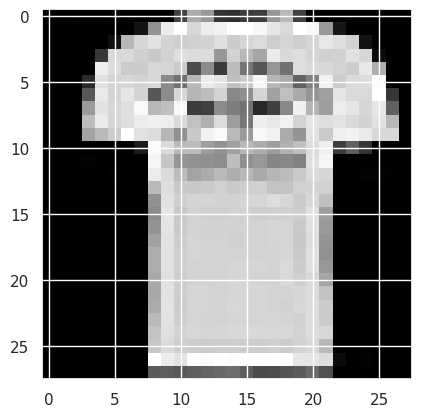

In [2]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

# Show the first training example.
print('Label: %s' %label_names[Y_train_fashion[0]])
plt.imshow(X_train_fashion[0], cmap='gray')
plt.show()

### MNIST

We also load the (digits) mnist dataset in the same way. Note that the number of train/test examples as well as the data shapes are identical to fashion_mnist.

11490434/11490434 [==============================] - 0s 0us/step
Label: 3


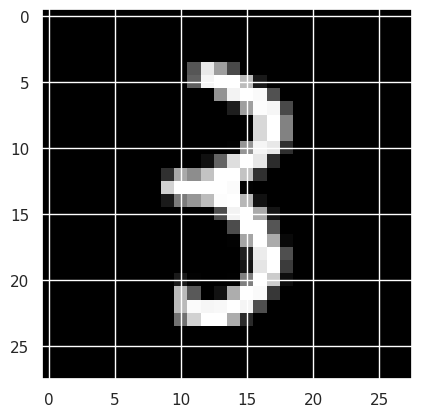

In [3]:
from keras.datasets import mnist

# Load the MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

# Show the first training example.
print('Label: %d' %Y_train_digits[0])
plt.imshow(X_train_digits[0], cmap='gray')
plt.show()

## Build a Model

We will write a build_model function that allows for a range of experiments on both datasets.

---
### Exercise 1 (50 points)

Fill in code that implements the build_model function, including all the arguments listed in the function definition [Note: the activation function parameter is only for the the hidden layers, use the appropriate final classification function for the final layer as usual].

In [20]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # YOUR CODE HERE
  optimizer_classes = {
      'SGD': tf.keras.optimizers.SGD,
      'Adam': tf.keras.optimizers.Adam
  }
  if optimizer not in optimizer_classes:
    raise ValueError(f"Invalid optimizer {optimizer} in the function input.")
  optimizer_class = optimizer_classes[optimizer]
  optimizer_instance = optimizer_class(learning_rate = learning_rate)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(tf.keras.Input(shape=(784,),name='Input'))

  #Hidden layer
  for hidden_layer_size in hidden_layer_sizes:
    model.add(tf.keras.layers.Dense(
        units = hidden_layer_size,
        activation = activation)
    )
  #Output layer
  model.add(keras.layers.Dense(
      units =n_classes,
      activation = 'softmax',
      name = 'Output'
  ))

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimizer_instance,
                metrics=['accuracy'])
  return model

---

## Run Experiments

We can now run a suite of experiments to see how the hyperparameters and layer sizes effect performance. The train_and_evaluate function below can be used to run experiments and retrieve results.

In [54]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5):

  # Build the model.
  model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Select the dataset.
  if data == 'digits':
    X_train = X_train_digits
    X_test = X_test_digits
    Y_train = Y_train_digits
    Y_test = Y_test_digits
  elif data == 'fashion':
    X_train = X_train_fashion
    X_test = X_test_fashion
    Y_train = Y_train_fashion
    Y_test = Y_test_fashion
  else:
    raise 'Unsupported dataset: %s' %data

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['accuracy']

  # updated for easier experiments
  model_summary = []
  model.summary(print_fn=lambda x: model_summary.append(x))
  model_summary = "\n".join(model_summary)

  return round(test_accuracy,4), model_summary
#print('Test Accuracy: %1.4f' %train_and_evaluate()) removed


---
### Exercise 2 (50 points)

Run experiments and fill in the test results in the table below. Feel free to extend the table to more experiments as you see fit.

#### Student Solution

DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-
digits|[128]|tanh|SGD|0.01|101770|0.9142
digits|[128]|relu|SGD|0.01|101770|0.9211
digits|[256]|relu|Adam|0.01|203530|0.9689
digits|[128,256]|relu|Adam|0.01|136074|0.9657
digits|[128]|relu|Adam|0.01|101770|0.9676
digits|[256,128]|relu|Adam|0.01|235146|0.9667
-
fashion|[128]|tanh|SGD|0.01|101770|0.8269
fashion|[128]|relu|SGD|0.01|101770|0.8294
fashion|[256]|relu|Adam|0.01|203530|0.8546
fashion|[128,256]|relu|Adam|0.01|136074|0.8472
fashion|[128]|relu|Adam|0.01|101770|0.8479
fashion|[256,128]|relu|Adam|0.01|235146|0.8536


Training...


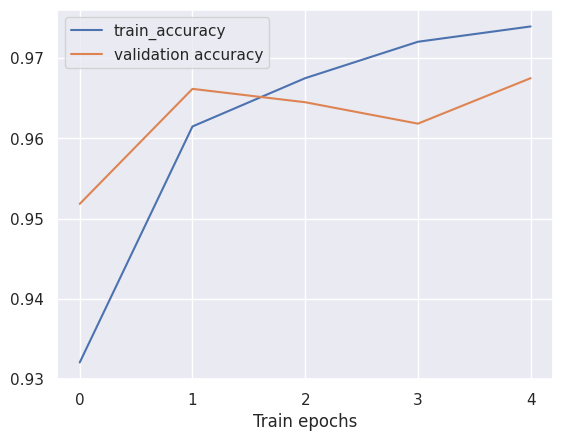

(0.9676,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 128)               100480    \n                                                                 \n Output (Dense)              (None, 10)                1290      \n                                                                 \n=================================================================\nTotal params: 101770 (397.54 KB)\nTrainable params: 101770 (397.54 KB)\nNon-trainable params: 0 (0.00 Byte)\n_______________________________________________________

In [55]:
train_and_evaluate(data='digits',
                       hidden_layer_sizes=[128],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5)


Training...


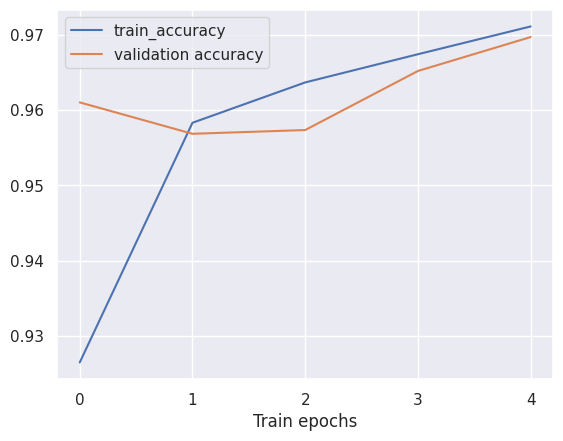

(0.9667,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 256)               200960    \n                                                                 \n dense_1 (Dense)             (None, 128)               32896     \n                                                                 \n Output (Dense)              (None, 10)                1290      \n                                                                 \n=================================================================\nTotal params: 235146 (918.54 K

In [56]:
train_and_evaluate(data='digits',
                       hidden_layer_sizes=[256,128],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


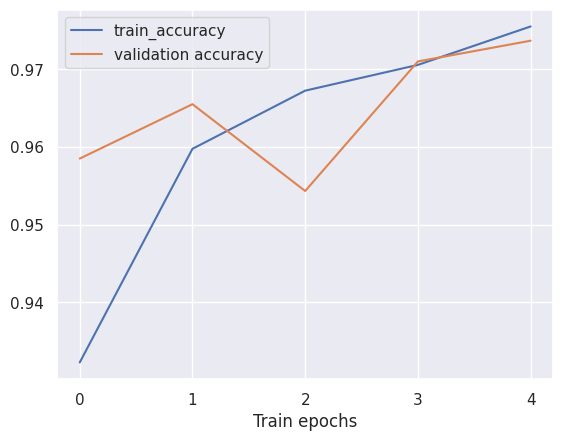

(0.9689,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 256)               200960    \n                                                                 \n Output (Dense)              (None, 10)                2570      \n                                                                 \n=================================================================\nTotal params: 203530 (795.04 KB)\nTrainable params: 203530 (795.04 KB)\nNon-trainable params: 0 (0.00 Byte)\n_______________________________________________________

In [57]:
train_and_evaluate(data='digits',
                       hidden_layer_sizes=[256],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


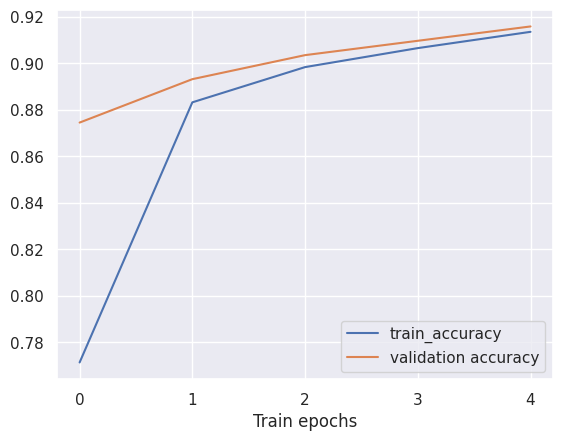

(0.9211,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 128)               100480    \n                                                                 \n Output (Dense)              (None, 10)                1290      \n                                                                 \n=================================================================\nTotal params: 101770 (397.54 KB)\nTrainable params: 101770 (397.54 KB)\nNon-trainable params: 0 (0.00 Byte)\n_______________________________________________________

In [59]:
train_and_evaluate(data='digits',
                       hidden_layer_sizes=[128],
                       activation='relu',
                       optimizer='SGD',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


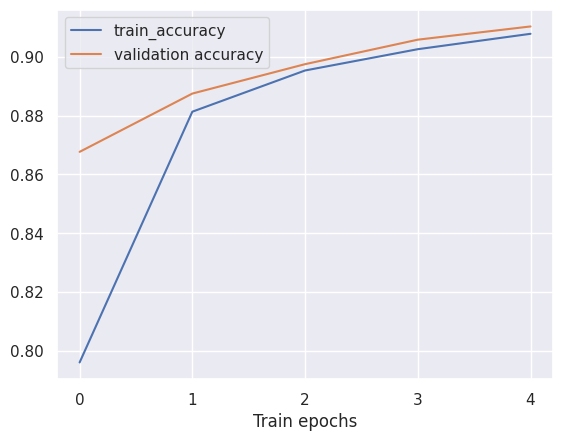

(0.9142,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 128)               100480    \n                                                                 \n Output (Dense)              (None, 10)                1290      \n                                                                 \n=================================================================\nTotal params: 101770 (397.54 KB)\nTrainable params: 101770 (397.54 KB)\nNon-trainable params: 0 (0.00 Byte)\n_______________________________________________________

In [60]:
train_and_evaluate(data='digits',
                       hidden_layer_sizes=[128],
                       activation='tanh',
                       optimizer='SGD',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


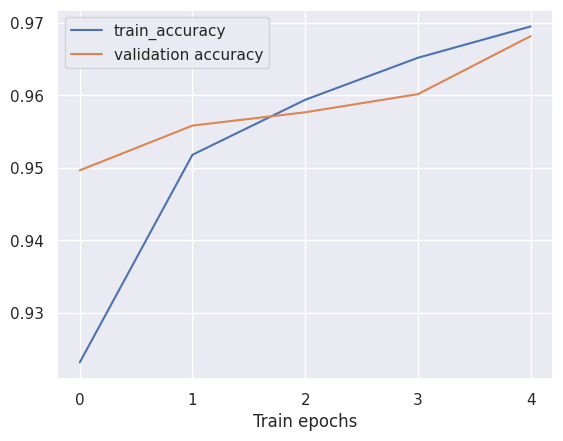

(0.9657,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 128)               100480    \n                                                                 \n dense_1 (Dense)             (None, 256)               33024     \n                                                                 \n Output (Dense)              (None, 10)                2570      \n                                                                 \n=================================================================\nTotal params: 136074 (531.54 K

In [71]:
train_and_evaluate(data='digits',
                       hidden_layer_sizes=[128,256],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


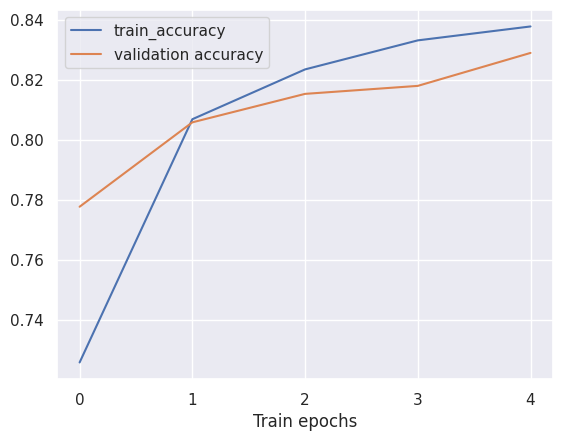

(0.8269,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 128)               100480    \n                                                                 \n Output (Dense)              (None, 10)                1290      \n                                                                 \n=================================================================\nTotal params: 101770 (397.54 KB)\nTrainable params: 101770 (397.54 KB)\nNon-trainable params: 0 (0.00 Byte)\n_______________________________________________________

In [63]:
train_and_evaluate(data='fashion',
                       hidden_layer_sizes=[128],
                       activation='tanh',
                       optimizer='SGD',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


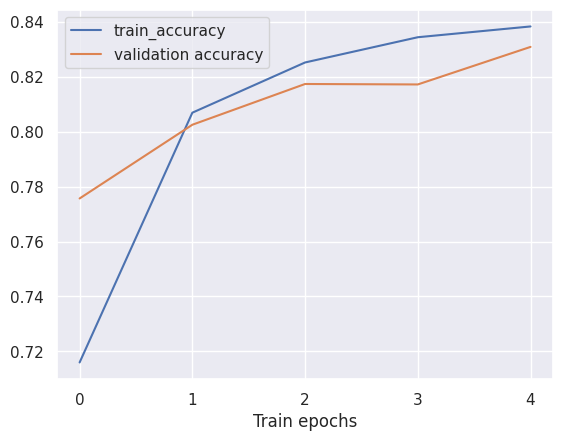

(0.8294,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 128)               100480    \n                                                                 \n Output (Dense)              (None, 10)                1290      \n                                                                 \n=================================================================\nTotal params: 101770 (397.54 KB)\nTrainable params: 101770 (397.54 KB)\nNon-trainable params: 0 (0.00 Byte)\n_______________________________________________________

In [64]:
train_and_evaluate(data='fashion',
                       hidden_layer_sizes=[128],
                       activation='relu',
                       optimizer='SGD',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


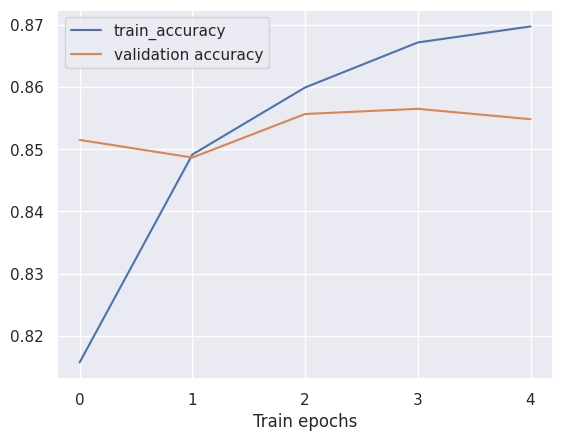

(0.8546,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 256)               200960    \n                                                                 \n Output (Dense)              (None, 10)                2570      \n                                                                 \n=================================================================\nTotal params: 203530 (795.04 KB)\nTrainable params: 203530 (795.04 KB)\nNon-trainable params: 0 (0.00 Byte)\n_______________________________________________________

In [70]:
train_and_evaluate(data='fashion',
                       hidden_layer_sizes=[256],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


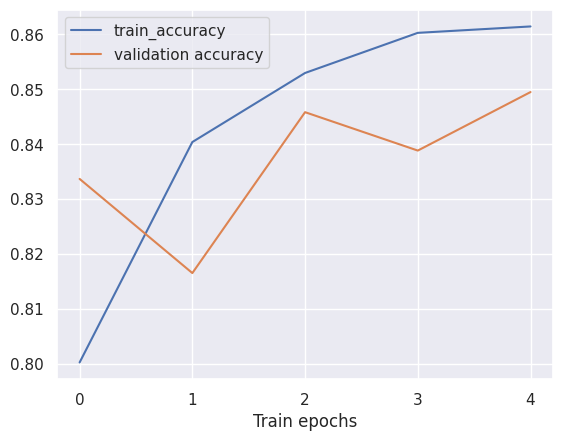

(0.8472,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 128)               100480    \n                                                                 \n dense_1 (Dense)             (None, 256)               33024     \n                                                                 \n Output (Dense)              (None, 10)                2570      \n                                                                 \n=================================================================\nTotal params: 136074 (531.54 K

In [69]:
train_and_evaluate(data='fashion',
                       hidden_layer_sizes=[128,256],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


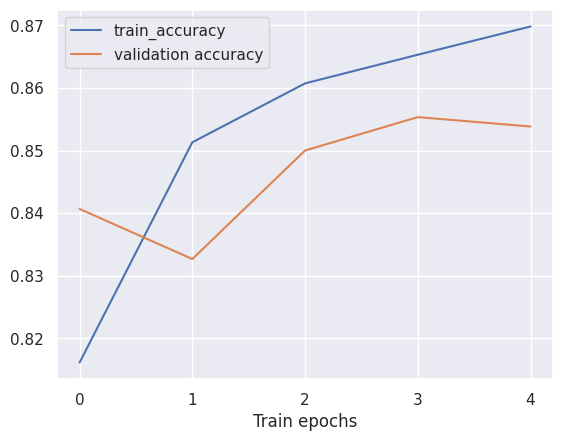

(0.8479,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 128)               100480    \n                                                                 \n Output (Dense)              (None, 10)                1290      \n                                                                 \n=================================================================\nTotal params: 101770 (397.54 KB)\nTrainable params: 101770 (397.54 KB)\nNon-trainable params: 0 (0.00 Byte)\n_______________________________________________________

In [66]:
train_and_evaluate(data='fashion',
                       hidden_layer_sizes=[128],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5)

Training...


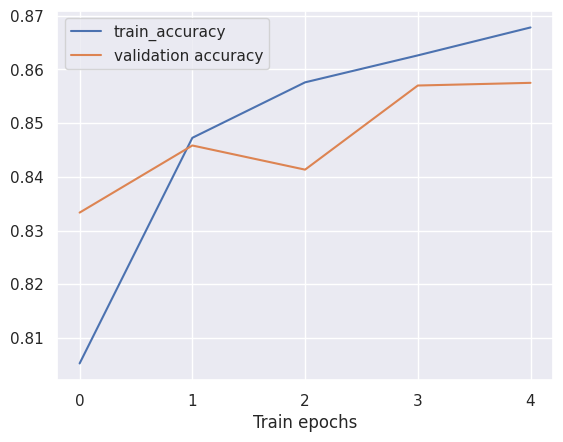

(0.8536,
 'Model: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n flatten (Flatten)           (None, 784)               0         \n                                                                 \n Input (InputLayer)          multiple                  0         \n                                                                 \n dense (Dense)               (None, 256)               200960    \n                                                                 \n dense_1 (Dense)             (None, 128)               32896     \n                                                                 \n Output (Dense)              (None, 10)                1290      \n                                                                 \n=================================================================\nTotal params: 235146 (918.54 K

In [68]:
train_and_evaluate(data='fashion',
                       hidden_layer_sizes=[256,128],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5)